In [9]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn

from sklearn.ensemble import AdaBoostRegressor # Random Forest

# Package for data partitioning
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

# Import packages to implement Stratified K-fold CV
from sklearn.model_selection import KFold # For creating folds

# Import Package to implement GridSearch CV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report,r2_score, mean_squared_error
# Importing package for Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

# Package to record time
import time

# Package for Data pretty printer
from pprint import pprint

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [10]:
#Preprocessing data

df_traffic_volume = pd.read_csv('Traffic_Volume.csv')
df_traffic_volume.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [11]:
df_traffic_volume.drop('weather_description',axis=1,inplace=True)
#check missing values
df_traffic_volume['holiday'] = df_traffic_volume['holiday'].fillna('None')
df_traffic_volume['holiday']


0        None
1        None
2        None
3        None
4        None
         ... 
48199    None
48200    None
48201    None
48202    None
48203    None
Name: holiday, Length: 48204, dtype: object

In [12]:
df_traffic_volume['date_time'] = pd.to_datetime(df_traffic_volume['date_time'])
df_traffic_volume['month'] = df_traffic_volume['date_time'].dt.month_name()
df_traffic_volume['day'] = df_traffic_volume['date_time'].dt.day_name()
df_traffic_volume['time'] = df_traffic_volume['date_time'].dt.hour
df_traffic_volume.drop('date_time',axis=1,inplace=True)

In [13]:
df_traffic_volume.isna().sum()

holiday           0
temp              0
rain_1h           0
snow_1h           0
clouds_all        0
weather_main      0
traffic_volume    0
month             0
day               0
time              0
dtype: int64

In [14]:
#create predictors and response variable
X_traffic= df_traffic_volume.drop(columns = ['traffic_volume'])
y_traffic = df_traffic_volume['traffic_volume']

In [15]:
#transform categorical predictors into dummies
X_traffic_cate_var = ['holiday','weather_main','month','day','time']
X_traffic_encoded = pd.get_dummies(X_traffic, columns = X_traffic_cate_var)

In [16]:
X_traffic_encoded

,temp,rain_1h,snow_1h,clouds_all,holiday_Christmas Day,holiday_Columbus Day,holiday_Independence Day,holiday_Labor Day,holiday_Martin Luther King Jr Day,holiday_Memorial Day,...,time_14,time_15,time_16,time_17,time_18,time_19,time_20,time_21,time_22,time_23
0,288.28,0.0,0.0,40,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,289.36,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,289.58,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,290.13,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,291.14,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48199,283.45,0.0,0.0,75,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
48200,282.76,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
48201,282.73,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48202,282.09,0.0,0.0,90,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [17]:
#partition data into train/test dataset
#create cv folds
train_X_traffic, test_X_traffic, train_y_traffic, test_y_traffic = train_test_split(X_traffic_encoded, y_traffic, test_size = 0.2, random_state = 1)
folds_3 = KFold(n_splits = 3, shuffle = True, random_state = 100)

In [18]:
#initiate model type
xg_reg_mod = XGBRegressor(random_state = 42)

In [19]:
hyperparameters_rand = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2], #gamma 
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}


In [20]:
#perform randCV
xg_reg_rand_cv = RandomizedSearchCV(estimator = xg_reg_mod, 
                              param_distributions = hyperparameters_rand,
                              n_iter = 100,
                              scoring = 'r2', 
                              cv = folds_3, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

In [21]:
xg_reg_rand_cv.fit(train_X_traffic, train_y_traffic) 

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=100, shuffle=True),
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=No...
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=42, ...),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'min_child_weight': [1, 3, 5],
                                        'n_estimators': [50, 100, 200],
                                        'subsample': [0.7, 0.8, 0.9]},
                   random_state=42, scoring='r2', verbose=1)

In [22]:
# Return set of parameters with the best performance
print(xg_reg_rand_cv.best_params_)

# Return the performance metric score
print(xg_reg_rand_cv.best_score_)

{'subsample': 0.9, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 7, 'learning_rate': 0.2, 'colsample_bytree': 0.9}
0.947709883897026


In [23]:
y_pred_test_xg = xg_reg_rand_cv.predict(test_X_traffic)
r2_score(test_y_traffic,y_pred_test_xg)

0.9527844533359204

In [24]:
mean_squared_error(test_y_traffic, y_pred_test_xg, squared=False)

430.47609124666013

In [25]:
bestRegXGboost = xg_reg_rand_cv.best_estimator_

In [29]:
midterm_pickle_xg = open('midtermXgBoost_hour_cat_fixed.pickle','wb')
pickle.dump(bestRegXGboost, midterm_pickle_xg)
midterm_pickle_xg.close()

In [27]:
# Displaying feature importance as a dataframe

importance = bestRegXGboost.feature_importances_ #gini index purity reduction

feature_imp_traffic_reg_xg = pd.DataFrame(list(zip(train_X_traffic.columns, importance)),
               columns = ['Feature', 'Importance'])

feature_imp_traffic_reg_xg = feature_imp_traffic_reg_xg.sort_values('Importance', ascending = False).reset_index(drop = True)

feature_imp_traffic_reg_xg

,Feature,Importance
0,time_4,0.158387
1,time_2,0.146740
2,time_1,0.144586
3,time_3,0.127848
4,time_0,0.126390
...,...,...
65,holiday_Christmas Day,0.000023
66,holiday_Independence Day,0.000013
67,holiday_Martin Luther King Jr Day,0.000000
68,weather_main_Smoke,0.000000


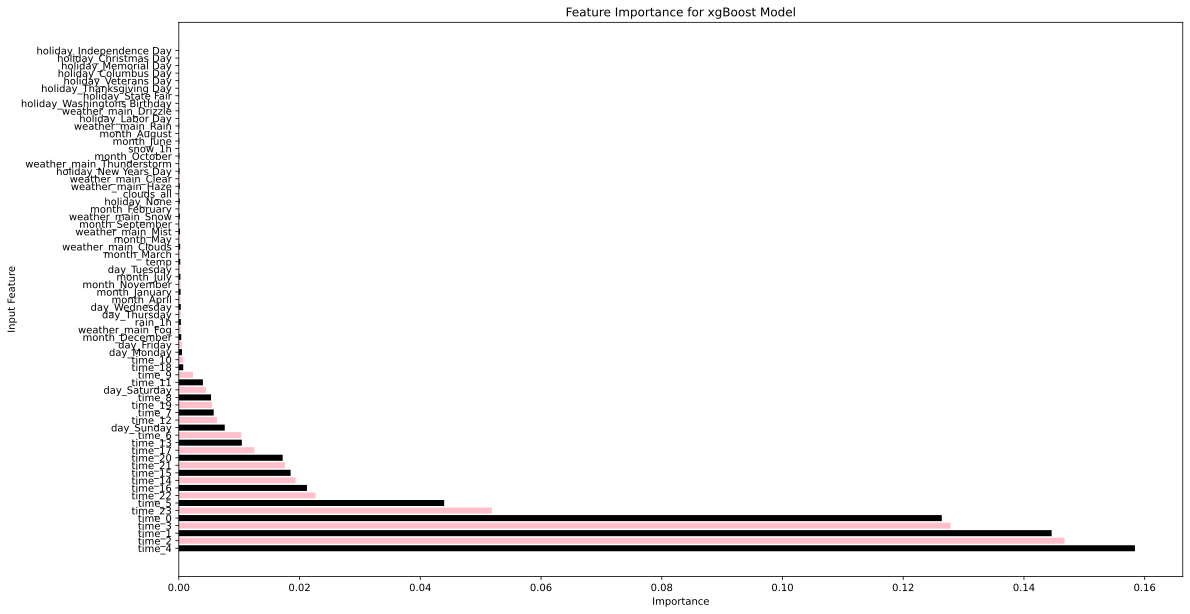

In [35]:
# Selecting features with non-zero importance values
feature_imp_nonzero_traffic_reg_xg = feature_imp_traffic_reg_xg[feature_imp_traffic_reg_xg['Importance'] != 0.0]

# Bar plot
plt.figure(figsize=(18, 10), dpi = 100)
plt.barh(feature_imp_nonzero_traffic_reg_xg['Feature'], feature_imp_nonzero_traffic_reg_xg['Importance'], color = ['black', 'pink'])

plt.xlabel("Importance")
plt.ylabel("Input Feature")
plt.title("Feature Importance for xgBoost Model");